<a href="https://colab.research.google.com/github/mohdimrandev/Leveraging-Machine-Learning-for-Diabetes-Detection/blob/main/type2_diabetes_prediction_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIBRARY PREPARATION**

In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format',  '{:.2f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler,LabelEncoder
from sklearn.metrics import roc_auc_score,roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# **Data Collection**

In [ ]:
df = pd.read_csv("diabetes.csv")
df_copy = df.copy()
df_copy.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# **EDA**

## 1. DATA EXPLORATION

In [ ]:
def check_df(data, head=5):
    print("\n******Shape******")
    print(f'Shape     : {df.shape}\n'
          f'Size      : {df.size}\n'
          f'Dimension : {df.ndim}')
    print("\n******Types******")
    print(data.dtypes)
    print("\n******Head******")
    print(data.head(head))
    print("\n******Tail******")
    print(data.tail(head))
    print("\n******Random Sampling******")
    print(data.sample(head))
    print("\n******Missing Values******")
    print(data.isnull().sum())
    print("\n******Duplicated Values******")
    print(data.duplicated().sum())
    print("\n******Unique Values******")
    print(data.nunique())
    print("\n******Describe******")
    print(data.describe().T)

In [ ]:
check_df(df)


******Shape******
Shape     : (768, 9)
Size      : 6912
Dimension : 2

******Types******
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

******Head******
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.60                      0.63   50        1
1            1       85             66             29        0 26.60                      0.35   31        0
2            8      183             64              0        0 23.30                      0.67   32        1
3            1       89             66             23       94 28.10                      0.17   21        0
4        

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20, print_results=True):
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int", "flaot"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    cat_cols = cat_cols + num_but_cat
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    if print_results:
        print(f'Observations {dataframe.shape[0]}')
        print(f'Variables:  {dataframe.shape[1]}')
        print(f'cat_cols:  {len(cat_cols)}')
        print(f'num_cols:  {len(num_cols)}')
        print(f'cat_but_car:  {len(cat_but_car)}')
        print(f'num_but_cat:  {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_copy)

Observations 768
Variables:  9
cat_cols:  1
num_cols:  8
cat_but_car:  0
num_but_cat:  1


## 2. HANDLING MISSING VALUE

In [ ]:
def check_missing_value(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [ ]:
check_missing_value(df_copy)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


There is no missing values in the dataset. Unless when I examine the dataset at the very beginnig of notebook, I realised some columns minimum values are "0" which is not possible for some reasons (except Pregnancies).


* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI  

Let's also check the BMI lower limit (12) for human survival.

In [ ]:
df_copy[df_copy['BMI'] < 12]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.00,0.23,54,1
49,7,105,0,0,0,0.00,0.30,24,0
60,2,84,0,0,0,0.00,0.30,21,0
81,2,74,0,0,0,0.00,0.10,22,0
145,0,102,75,23,0,0.00,0.57,21,0
371,0,118,64,23,89,0.00,1.73,21,0
426,0,94,0,0,0,0.00,0.26,25,0
494,3,80,0,0,0,0.00,0.17,22,0
522,6,114,0,0,0,0.00,0.19,26,0
684,5,136,82,0,0,0.00,0.64,69,0


Let's examine the zero-assigned rows and consider them as missing values of these variables.

In [ ]:
missing_value = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in missing_value:
    print(col, df_copy.loc[df_copy[col] == 0].shape[0])
    df_copy[col] = np.where(df_copy[col] == 0, np.nan, df_copy[col])

check_missing_value(df_copy)

Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65


In [ ]:
df_copy = df_copy.fillna(df_copy.groupby('Outcome').transform('median'))

## 3. OUTLIER DETECTION & HANDLING

In [ ]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return  low_limit, up_limit

In [ ]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
for col in num_cols:
    print(col, check_outlier(df_copy, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction True
Age False


In [ ]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
for col in num_cols:
    print(col, replace_with_thresholds(df_copy, col))

Pregnancies None
Glucose None
BloodPressure None
SkinThickness None
Insulin None
BMI None
DiabetesPedigreeFunction None
Age None


## 4. CORRELATION

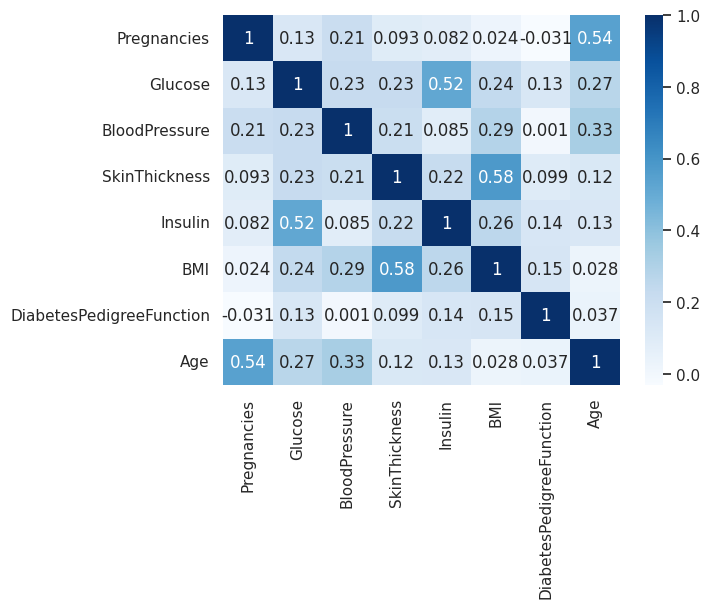

In [ ]:
corr = df_copy[num_cols].corr()
sns.heatmap(corr, cmap="Blues", annot=True);

## 5. FEATURE EXTRACTION

In [ ]:
def feature_extraction(dataframe):
    dataframe['Insulin_CAT'] = pd.cut(x=dataframe['Insulin'],
                                      bins=[0, 140, 199, np.inf],
                                      labels=["Normal", "Prediabetes", "Diabetes"])

    dataframe['BloodPressure_CAT'] = pd.cut(x=dataframe['BloodPressure'],
                                            bins=[0, 60, 80, 90, 120, np.inf],
                                            labels=["Low_Blood_Pressure", "Normal",
                                                    "Prehypertension", "Hypertension",
                                                    "Hypertensive_Crisis"])

    dataframe['Glucose_CAT'] = pd.cut(x=dataframe['Glucose'],
                                      bins=[0, 140, 199, np.inf],
                                      labels=["Normal", "Impaired_Glucose_Tolerance",
                                              "Diabetes"])

    dataframe['BMI_CAT'] = pd.cut(x=dataframe['BMI'],
                                  bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9,  np.inf],
                                  labels=["Underweight", "Healthy", "Overweight",
                                          "Obese_Class1", "Obese_Class2", "Obese_Class3"])

    dataframe['Age_CAT'] = pd.cut(x=dataframe['Age'],
                                  bins=[20, 40, 60, np.inf],
                                  labels=["Adult", "Middle_Age_Adult", "Senior_Adult"])

    dataframe.loc[(dataframe['Age'] > 40)
                  & (dataframe['BloodPressure_CAT'] == 'Hypertension')
                  & ((dataframe["BMI_CAT"] == "Overweight")
                     | (dataframe["BMI_CAT"] == "Obese_Class1")
                     | (dataframe["BMI_CAT"] == "Obese_Class2")
                     | (dataframe["BMI_CAT"] == "Obese_Class3")), "Life_Level_CAT"] = "At_Risk"

    dataframe['Life_Level_CAT'].fillna('Not_Risk', inplace = True)

In [ ]:
feature_extraction(df_copy)

<a id="section-six"></a>
# **VISUALIZATION**

## 1. OUTLIERS

In [ ]:
def boxplot_for_outliers(dataframe):
    a = 2
    b = 4
    c = 1
    results = []
    colors=[]

    palette_set3 = sns.color_palette("Set3",len(num_cols))
    for color in palette_set3.as_hex():
        colors.append(color)
    colour_num_cols = zip(num_cols, colors)

    fig = plt.figure(figsize = (20, 10))
    for col, color in colour_num_cols:
        plt.subplot(a, b, c)
        sns.boxplot(dataframe[col], color=color)
        plt.xlabel(f'{dataframe[col].name}', size=15)
        c = c + 1
        results.append(check_outlier(dataframe, col))
        if True in results:
            plt.suptitle(f'Original Dataset', size=18);
        else:
            plt.suptitle(f'Cleaned Dataset', size=18);
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)
    plt.show()

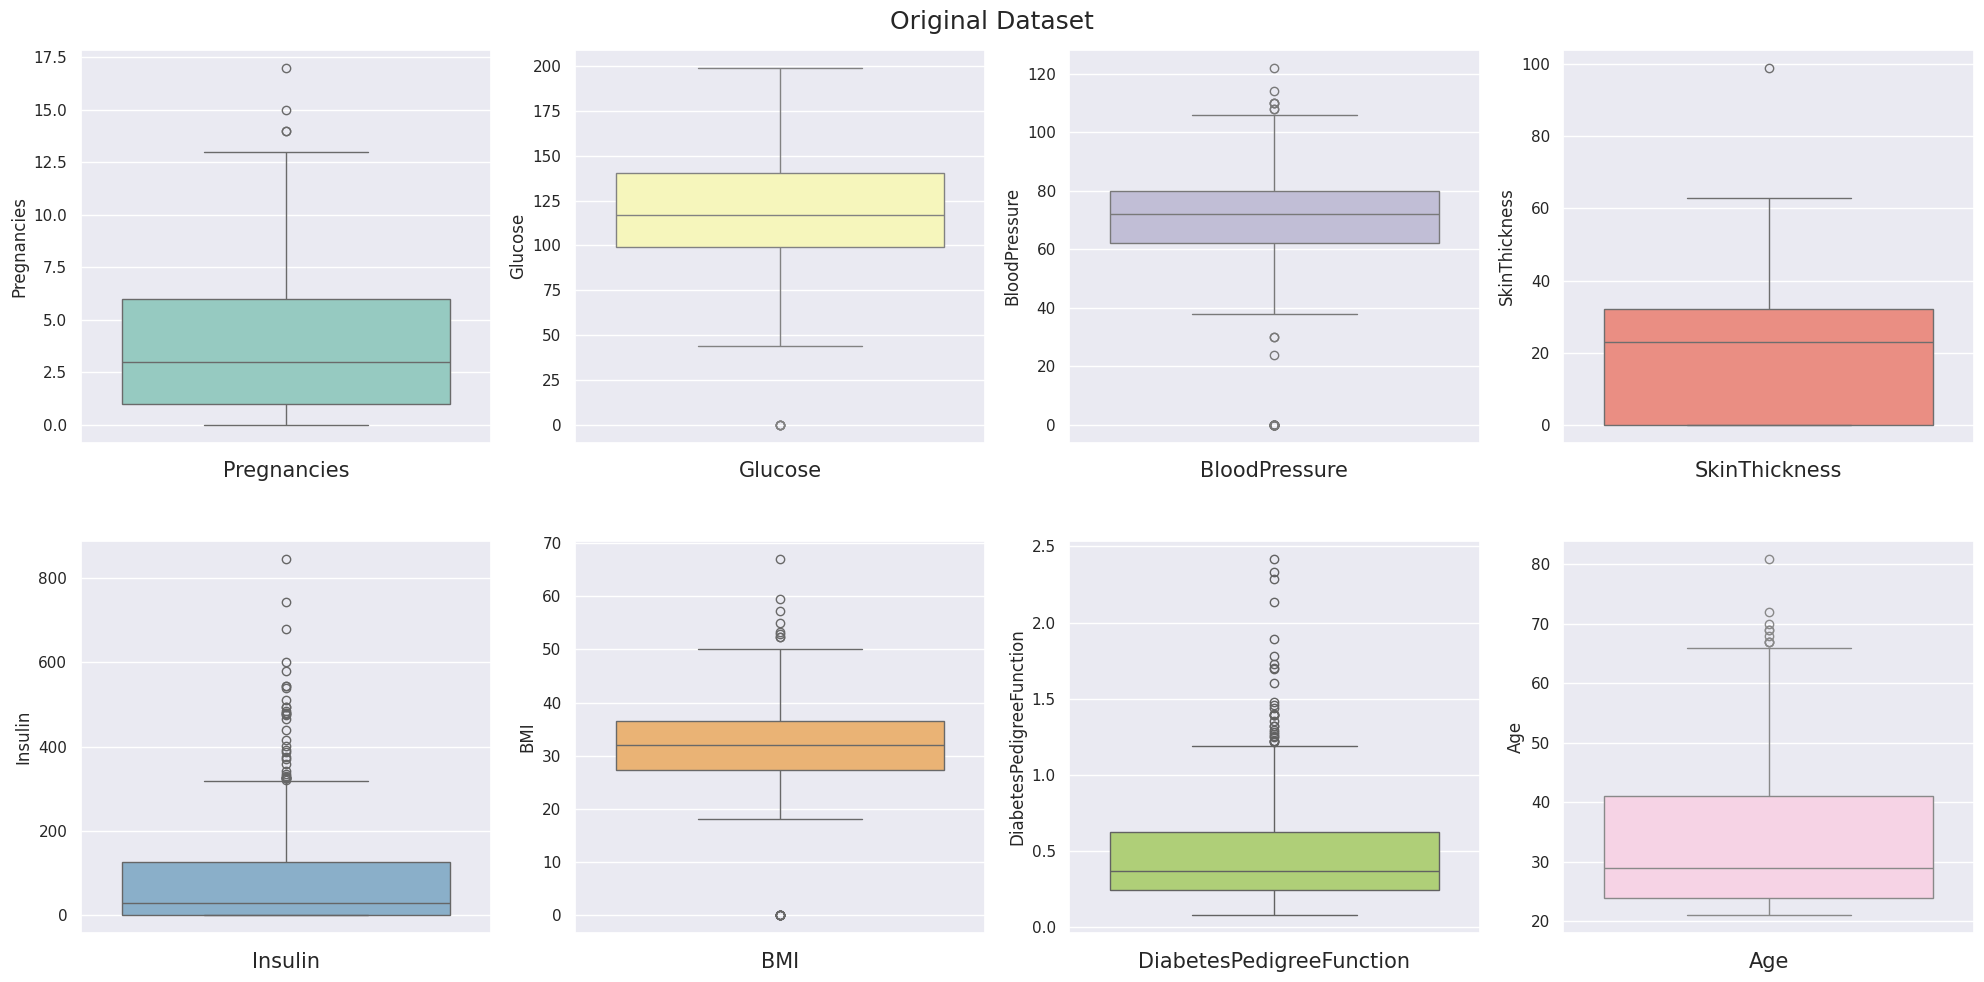

In [ ]:
boxplot_for_outliers(df)

## 2. DISTRIBUTION

In [ ]:
def hist_plot(dataframe, title):
    a = 4
    b = 2
    c = 1
    colors=[]
    missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    palette_set2 = sns.color_palette("Paired",len(num_cols))
    for color in palette_set2.as_hex():
        colors.append(color)
    colour_num_cols = zip(missing_cols, colors)

    fig = plt.figure(figsize = (13, 15))
    for col, color in colour_num_cols:
        plt.subplot(a, b, c)
        sns.histplot(data=dataframe, x=col, kde=True, color=color);
        plt.xlabel(f'{dataframe[col].name}', size=15)
        c = c + 1
        plt.suptitle(title, size=18);

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)
    plt.show()

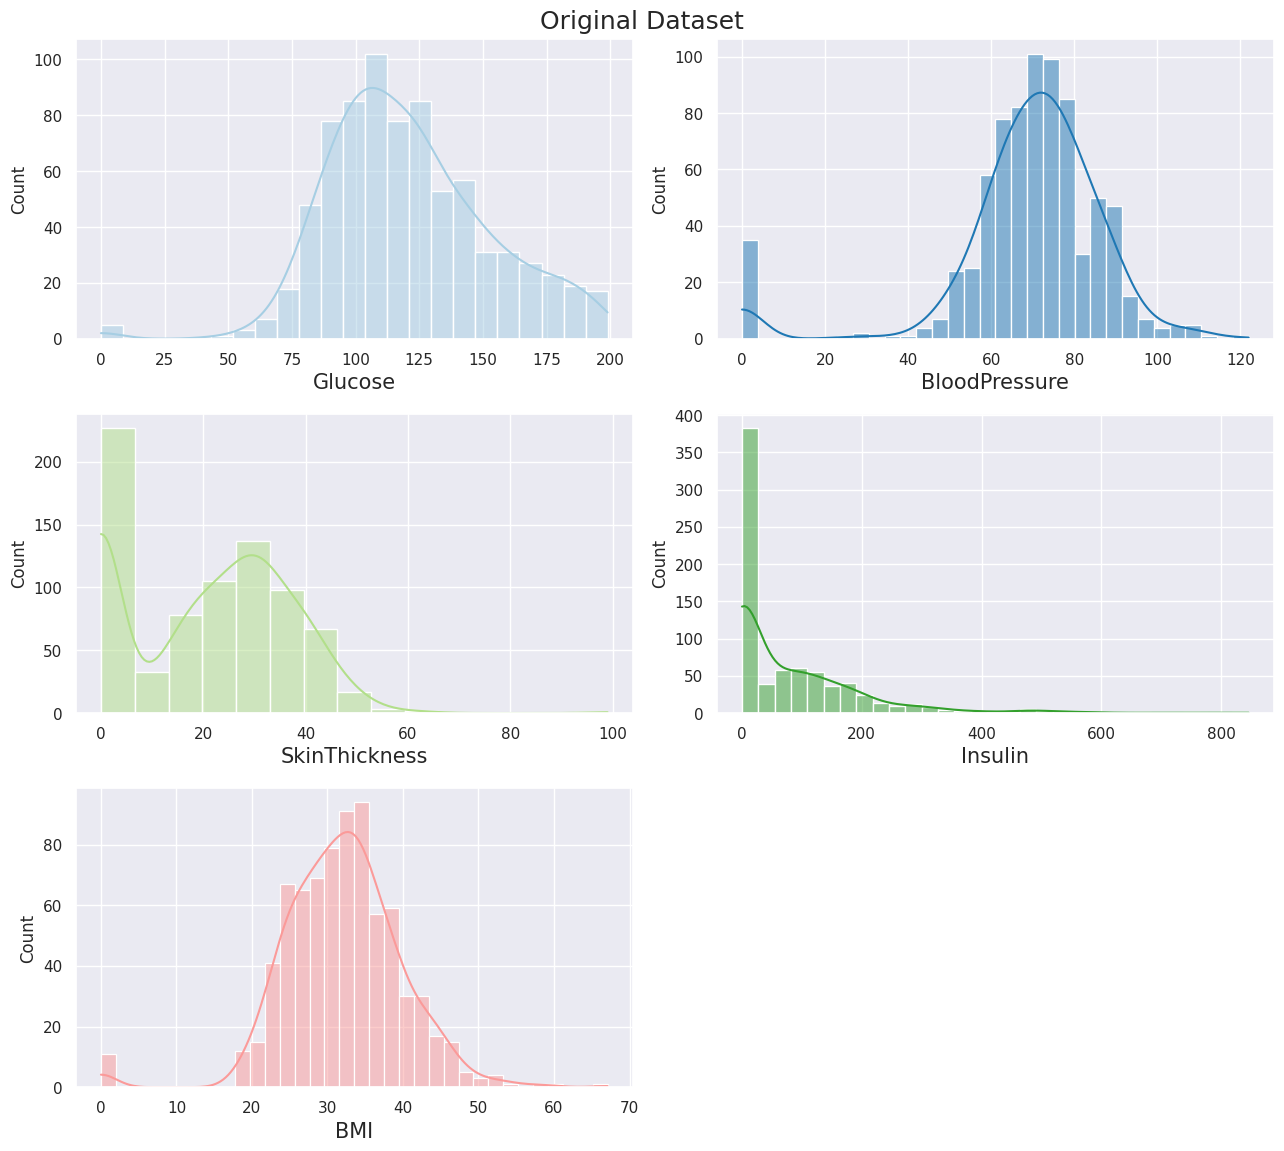

In [ ]:
hist_plot(df, title='Original Dataset')

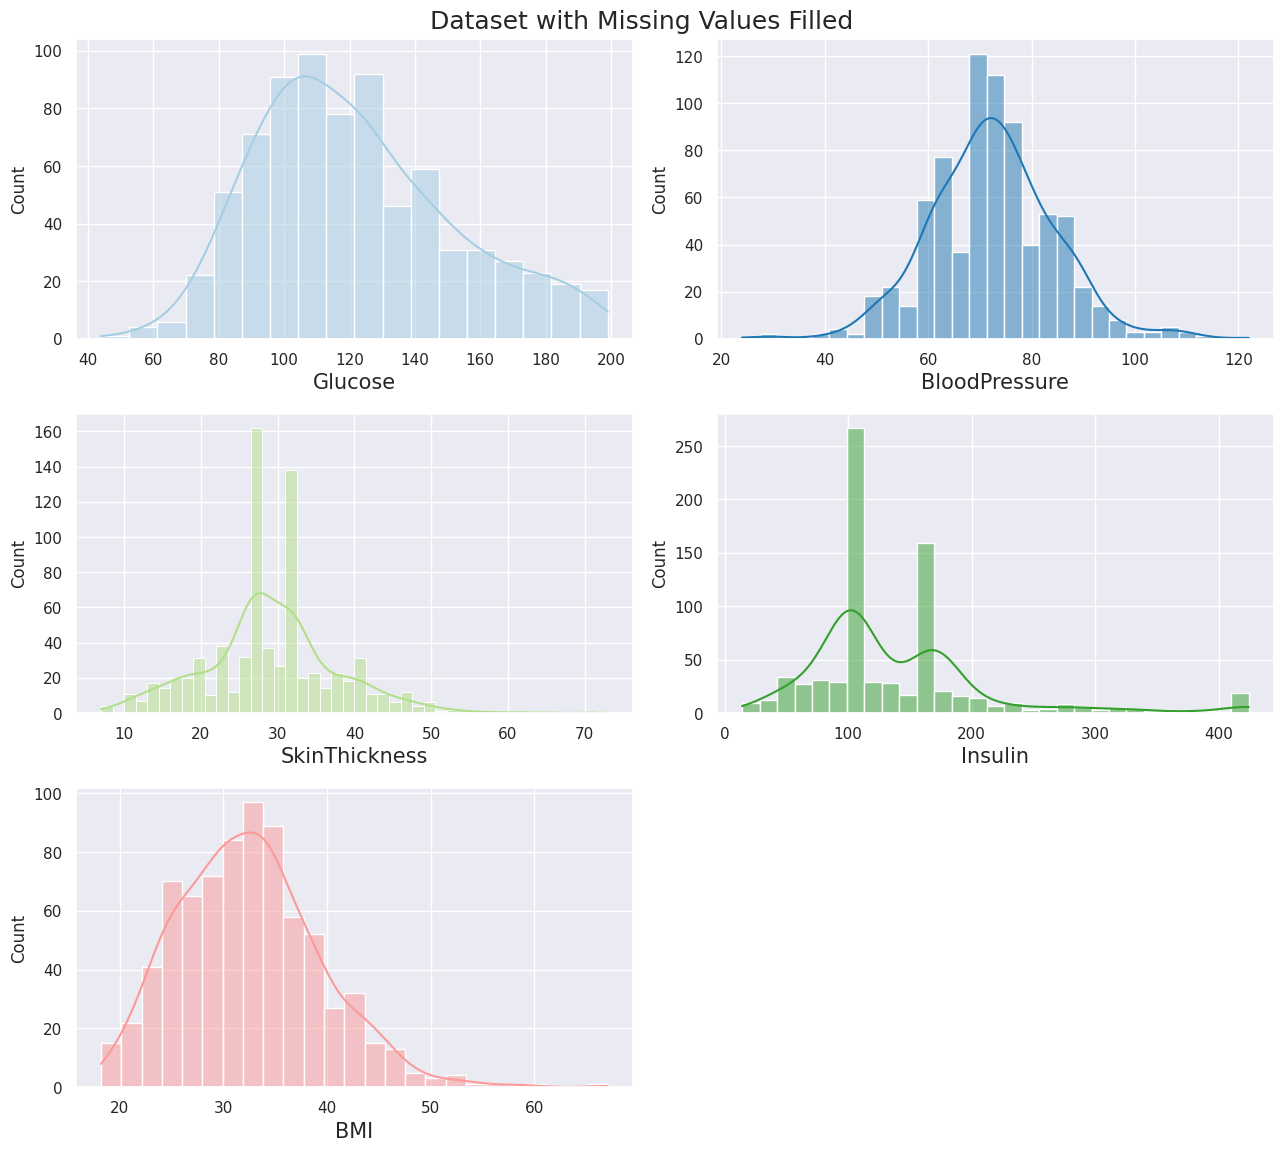

In [ ]:
hist_plot(df_copy, title='Dataset with Missing Values Filled')


## 3. DIABETES RATIO

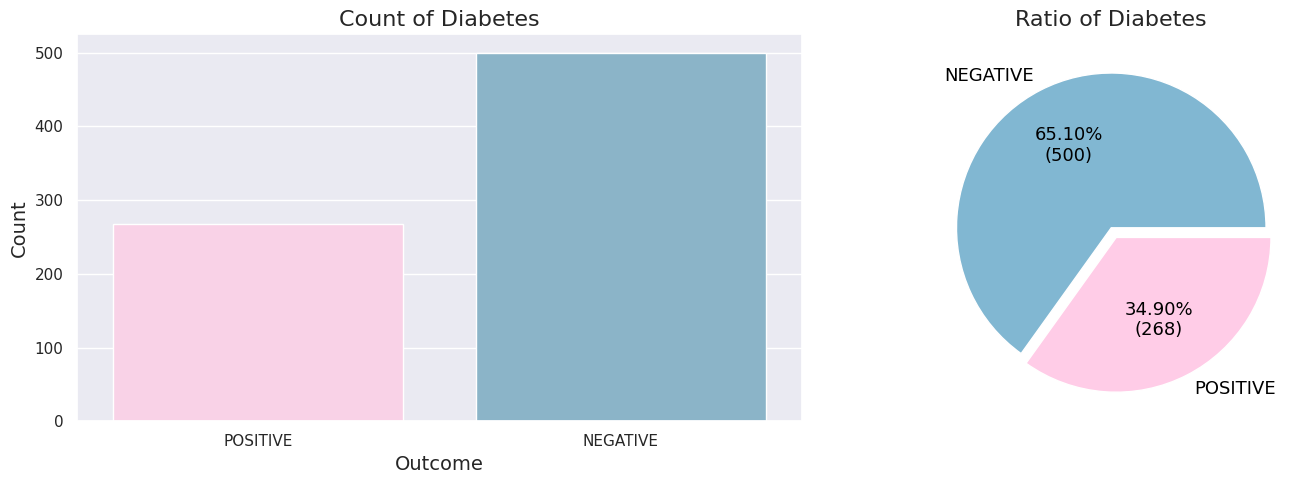

In [ ]:
fig,  axs = plt.subplots(1,2, figsize = (15, 5))

ax = sns.countplot(data=df_copy,
                   x=df_copy['Outcome'].replace({0: 'NEGATIVE', 1: 'POSITIVE'}),
                   ax = axs[0],
                   palette=["#ffcce7", "#81b7d2"]);

ax.set_xlabel('Outcome', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
axs[0].set_title("Count of Diabetes", fontsize=16)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.2f}%\n({absolute:d})"

ax2 = df_copy['Outcome'].value_counts().plot.pie(explode=[0,0.07],
                                                 colors=["#81b7d2", "#ffcce7"],
                                                 autopct=lambda pct: func(pct, df['Outcome'].value_counts()),
                                                 ylabel='',
                                                 labels=['NEGATIVE', 'POSITIVE'],
                                                 ax = axs[1],
                                                 textprops=dict(color="black", size=13));
axs[1].set_title("Ratio of Diabetes", fontsize=16)

plt.tight_layout()
plt.show()

## 4. VISUALIZATION of EXTRACTED FEATURES

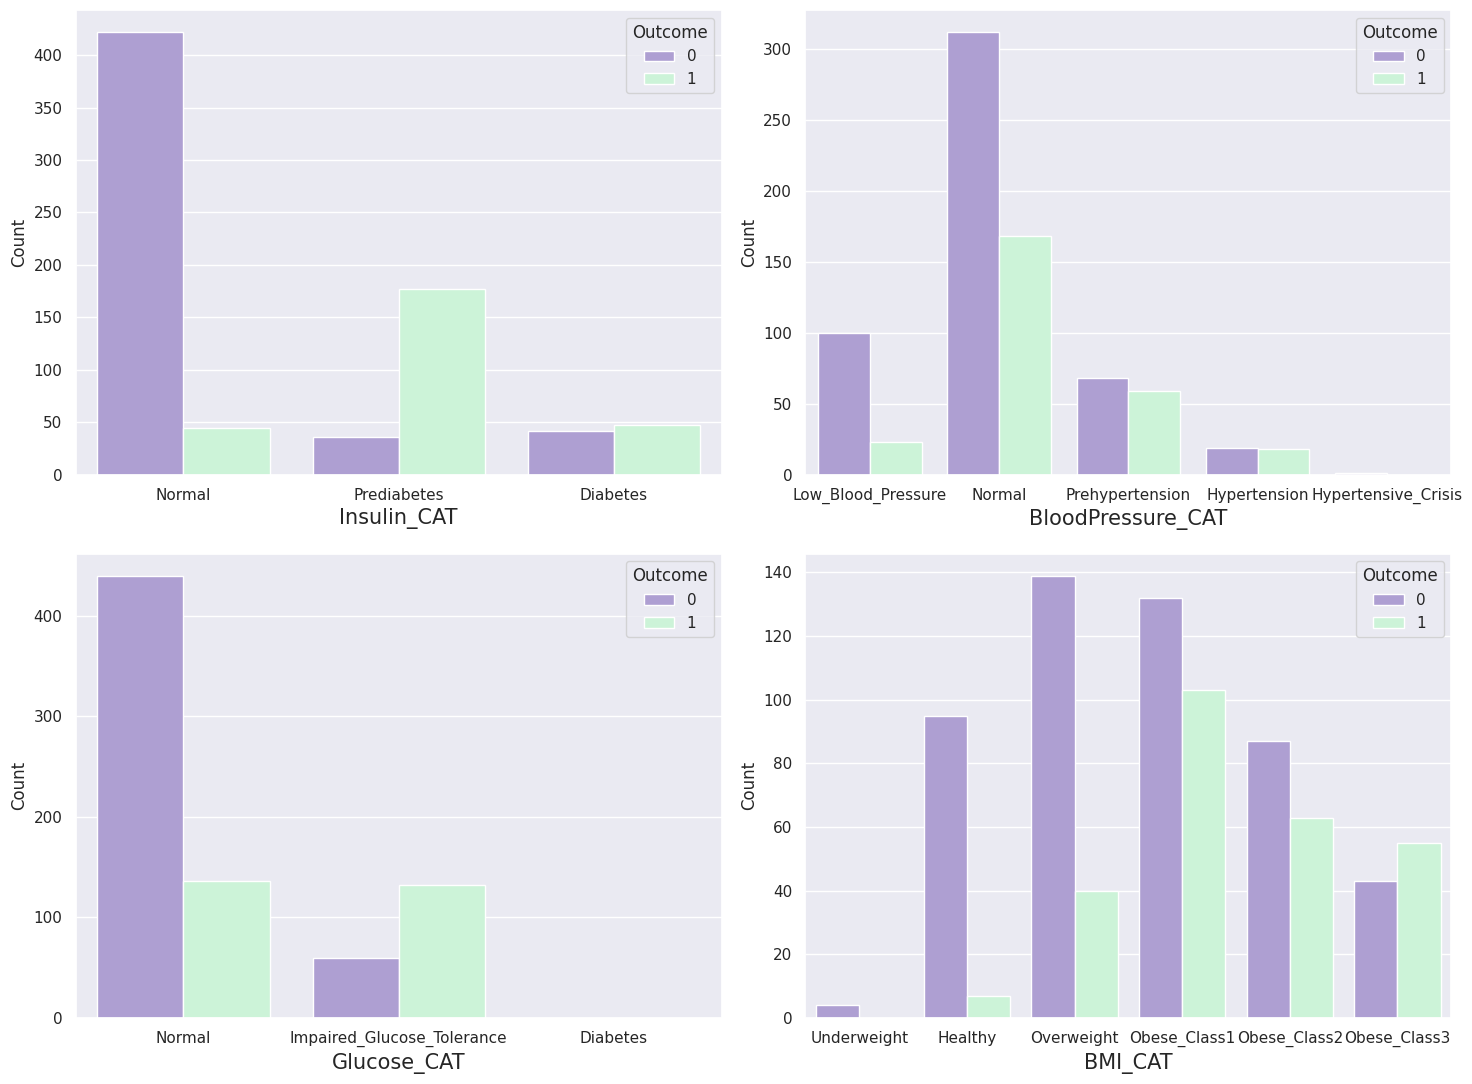

In [ ]:
new_cols = ["Insulin_CAT", "BloodPressure_CAT", "Glucose_CAT", "BMI_CAT"]

a = 2
b = 2
c = 1
fig = plt.figure(figsize = (15, 11))
for col in new_cols:
    plt.subplot(a, b, c)
    ax = sns.countplot(df_copy,
                       x=df_copy[col],
                       hue=df.Outcome,
                       palette=["#AA96DA", "#C5FAD5"])
    plt.ylabel('Count')
    plt.xlabel(f'{col}', size=15)
    c = c + 1

plt.tight_layout()
plt.subplots_adjust(hspace=0.17)
plt.show()

<a id="section-eleven"></a>
# **MACHINE LEARNING**

In [ ]:
def one_hot_encoder(dataframe, categorical_col, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_col, drop_first=drop_first)
    return dataframe

In [ ]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [ ]:
def data_prep(X, y):

    index = X.index
    dataframe = X.merge(y.to_frame(), left_index=True, right_index=True).set_index(index)

    # get cols
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, print_results=False)

    # replace outliers
    [replace_with_thresholds(dataframe, col) for col in num_cols]

    # Treat zero values as missing values after acquiring domain knowledge
    missing_value = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    for col in missing_value:
        dataframe[col] = np.where(dataframe[col] == 0, np.nan, dataframe[col])
    dataframe = dataframe.fillna(dataframe.groupby('Outcome').transform('median'))

    # Feature Engineering
    feature_extraction(dataframe)

    # Scaling
    rs = RobustScaler()
    dataframe[num_cols] = rs.fit_transform(dataframe[num_cols])

    # binary encoding
    binary_cols = [col for col in dataframe.columns
                   if dataframe[col].dtype not in ["int64", "float64"]
                   and dataframe[col].nunique() == 2]
    for col in binary_cols:
        label_encoder(dataframe, col)

    # One-hot-encoding
    ohe_cols = [col for col in dataframe.columns if 12 >= dataframe[col].nunique() > 2]
    dataframe = one_hot_encoder(dataframe, ohe_cols, drop_first=True)

    X = dataframe.drop(["Outcome"], axis=1)
    y = dataframe["Outcome"]
    return X, y

In [ ]:
X = df.drop(["Outcome"], axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

🚀 First take a look baseline scores of raw datasets. That's why I fit the models just before data preprocessing.

In [ ]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X_train, y_train, scoring="accuracy")

Base Models....
accuracy: 0.7671 (LR) 
accuracy: 0.7182 (KNN) 
accuracy: 0.7215 (CART) 
accuracy: 0.7655 (RF) 
accuracy: 0.7638 (GBM) 
accuracy: 0.7443 (XGBoost) 
[LightGBM] [Info] Number of positive: 142, number of negative: 267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347188 -> initscore=-0.631422
[LightGBM] [Info] Start training from score -0.631422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
X_train, y_train = data_prep(X_train, y_train)
X_test, y_test = data_prep(X_test, y_test)

In [ ]:
def base_models(X, y):
    models = [("LR", LogisticRegression(solver='lbfgs', max_iter=3000)),
              ("KNN", KNeighborsClassifier()),
              ("CART", DecisionTreeClassifier()),
              ("RF", RandomForestClassifier()),
              ("GBM", GradientBoostingClassifier()),
              ("XGBoost", XGBClassifier(eval_metric='logloss')),
              ("LightGBM", LGBMClassifier()),
              ('CatBoost', CatBoostClassifier(verbose=False))
              ]
    for name, classifier in models:
        cv_results = cross_validate(classifier, X, y, cv=5, scoring="accuracy")
        print(f"Accuracy: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [ ]:
logreg_params = {"C": [0.01, 0.1, 1, 10, 100]}

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 5, 8],
              "n_estimators": [100, 200, 500]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6, 10]}

In [ ]:
classifiers = [
    ('LR', LogisticRegression(), logreg_params),
    ('KNN', KNeighborsClassifier(), knn_params),
    ('CART', DecisionTreeClassifier(), cart_params),
    ('RF', RandomForestClassifier(), rf_params),
    ('GBM', GradientBoostingClassifier(), gbm_params),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
    ('LightGBM', LGBMClassifier(), lightgbm_params),
    ('CatBoost', CatBoostClassifier(verbose=0), catboost_params)
]

In [ ]:
def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    print("\nHyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [ ]:
def voting_classifier(best_models, X, y):
    print("\nVoting Classifier...")
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [ ]:
def fit_models(X,y):
    base_models(X, y)
    best_models = hyperparameter_optimization(X, y)
    voting_clf = voting_classifier(best_models, X, y)
    return voting_clf, best_models

voting_clf, best_models = fit_models(X_train, y_train)

Accuracy: 0.8731 (LR) 
Accuracy: 0.8535 (KNN) 
Accuracy: 0.8339 (CART) 
Accuracy: 0.8877 (RF) 
Accuracy: 0.8909 (GBM) 
Accuracy: 0.8909 (XGBoost) 
[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348269 -> initscore=-0.626657
[LightGBM] [Info] Start training from score -0.626657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
lgbm_model = best_models['LightGBM'].fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

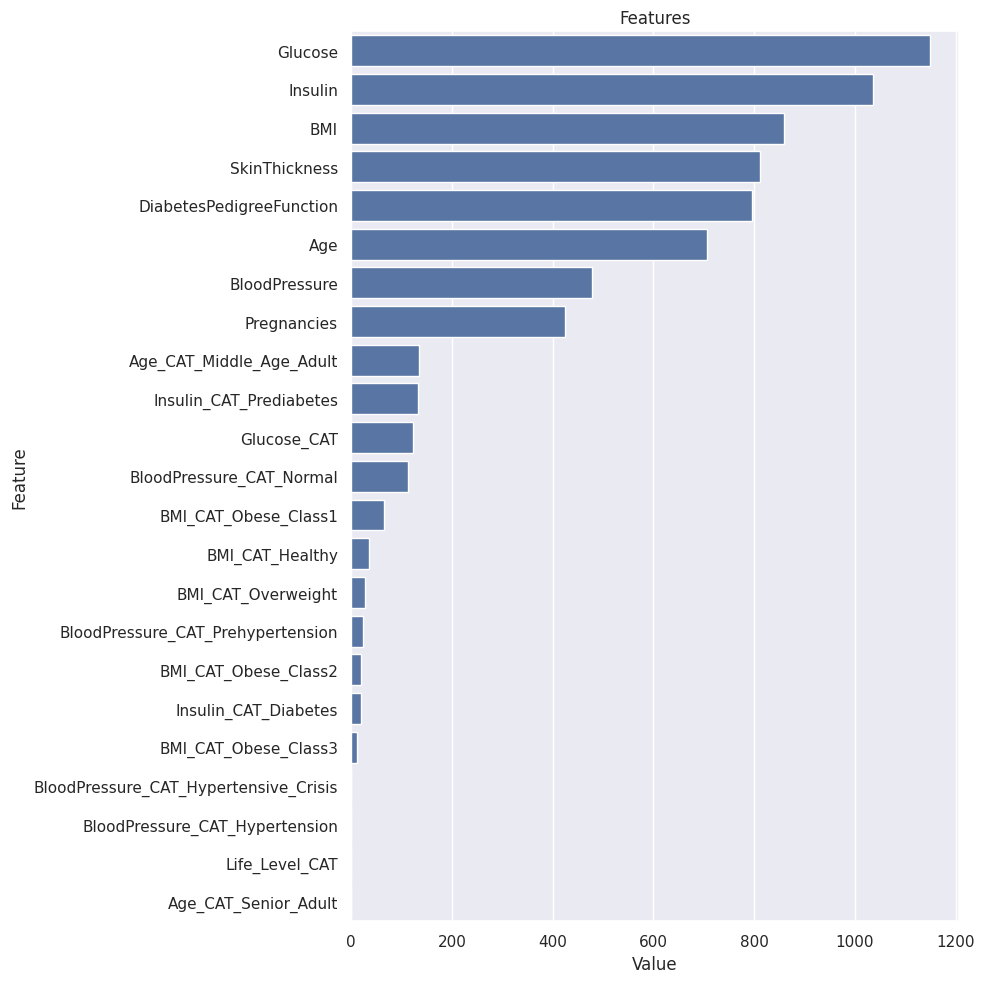

In [ ]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_,
                                'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

plot_importance(lgbm_model, X_train)

<a id="section-twelve"></a>
# **MODEL PERFORMANCE**


In [ ]:
y_pred = lgbm_model.predict(X_test)
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        99
           1       0.84      0.76      0.80        55

    accuracy                           0.86       154
   macro avg       0.86      0.84      0.85       154
weighted avg       0.86      0.86      0.86       154



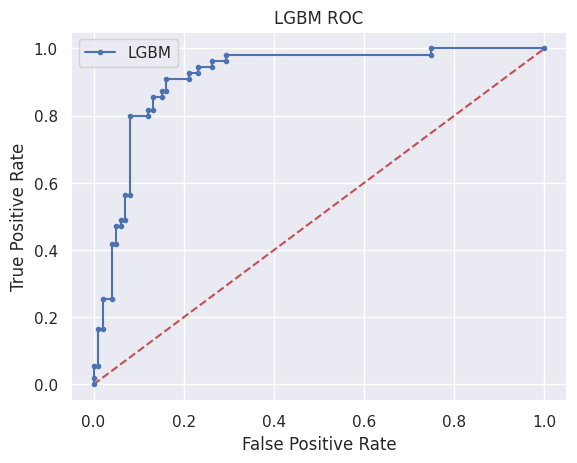

In [ ]:
lgbm_roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()

plt.plot([0,1],[0,1],'r--')
plt.plot(fpr, tpr, marker='.', label='LGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("LGBM ROC")
plt.legend()
plt.show()

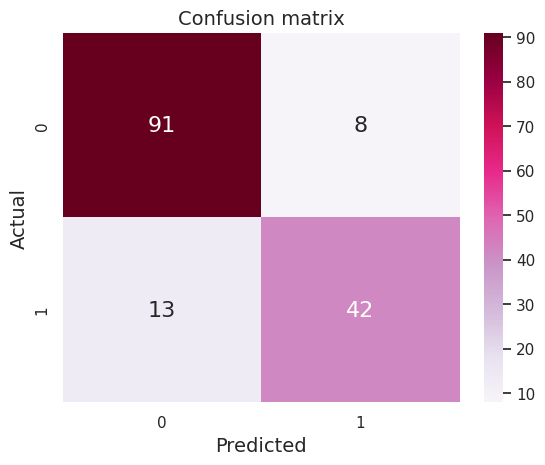

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix),
                annot=True,
                cmap="PuRd",
                annot_kws={"size": 16})
plt.title('Confusion matrix', size=14)
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14);

<a id="section-thirteen"></a>
# **CONCLUSION**

My finding shows that **Glucose, Insulin, and BMI**, respectively, have the most influence on a person's diabetes outcome. New features have more or less impact on accuracy. In addition, the effect of other preprocess technics should not be ignored.

In the table below, you can see the result of examining the **effectiveness of data preprocessing on training accuracy**, which is the core concept of the project.  First of all the algorithms were trained without data preprocess. Then some preprocessing techniques were applied to the raw data. To be more precise, these technics are:
* Handling Missing and Outlier Values
* Feature Extraction
* Feature Scaling

Hyperparameter optimization were applied to the chosen algorithms. LightGBM gives the best accuracy by a miniscule difference.

    
| Algorithm | Baseline Accuracy <br>Without Data Preprocess | Baseline Accuracy  <br>With Data Preprocess | Optimization
|  :---: | :---: |  :---: | :---:
| LR | 0.7671 | 0.8731 | 0.8828 |
| KNN | 0.7182 | 0.8535 | 0.8616 |
| CART | 0.7312 | 0.8354 | 0.8615 |
| RF | 0.7752 | 0.8893 | 0.8828|
| GBM | 0.7638 | 0.8893 | 0.8893  |
| XGBoost | 0.7508 | 0.8909 | 0.8974 |
| LightGBM | 0.7378 | 0.8925 | 0.9007 |
| CatBoost | 0.7818 | 0.8877 | 0.8991 |    
